In [1]:
import transformers
from transformers import BertModel, BertTokenizer,BertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
from matplotlib import pyplot as plt

transformers.logging.set_verbosity_error()
torch.cuda.empty_cache()

## Dataset

In [2]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
MAX_LEN = 100
BATCH_SIZE = 32
RANDOM_SEED = 42

In [3]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [4]:
train_stances = '../fnc-1/train_stances.csv'
train_bodies = '../fnc-1/train_bodies.csv'

stances_headlines =  pd.read_csv(train_stances)[:150]
bodies = pd.read_csv(train_bodies)
stances_bodies = stances_headlines.merge(bodies,on='Body ID')

In [5]:
len(stances_headlines)

150

In [6]:
class StancesDataset(Dataset):
    def __init__(self, headlines, bodies, stances, tokenizer, max_len):
        self.headlines = headlines
        self.bodies = bodies
        self.stances = stances
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.categories = {"unrelated": 0, "agree": 1, "discuss": 2, "disagree": 3}


    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        headline = self.headlines[idx]
        body = self.bodies[idx]
        stance = self.categories[self.stances[idx]]
        stanceVec = [0,0,0,0]
        stanceVec[stance] = 1

        inputs = self.tokenizer.encode_plus(
            headline,
            body,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            "onehotlabels": torch.tensor(stanceVec, dtype=torch.float),
            "labels": torch.tensor([stance], dtype=torch.long)
        }

## Model

In [7]:
class StanceDetectionModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.l1 = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _,pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                                 return_dict=False)
        output = self.l1(pooled_output)
        return F.softmax(output,dim=1)

In [8]:
# configuration = BertConfig(type_vocab_size = 4)
# model = BertForSequenceClassification(config = configuration)
# model = model.from_pretrained(PRE_TRAINED_MODEL_NAME, problem_type="single_label_classification", num_labels = 4)

In [9]:
# model.config

## Training

In [10]:
def train(batch_size, data, model, loss_fn,num_samples, device='cpu'):
    model = model.train()
    model.to(device)
    num_correct_predictions = 0
    num_samples = len(data)
    training_loss = []

    batch_oldtime = time.time()
    for i, input_data in enumerate(data):
        batch_newtime = time.time()
        batch_oldtime = batch_newtime
        
        input_ids = input_data['input_ids'].to(device)
        attention_mask = input_data['attention_mask'].to(device)
        token_type_ids = input_data['token_type_ids'].to(device)
        onehotlabels = input_data['onehotlabels'].to(device).squeeze()
        labels = input_data['labels'].to(device).squeeze()
        optimizer.zero_grad()
        output = model(input_ids, attention_mask, token_type_ids)
        preds = torch.argmax(output, dim=1)
        num_correct_predictions += torch.sum(preds == labels)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_loss.append(loss.item())
    return num_correct_predictions.item()/num_samples, np.mean(training_loss)


In [11]:
def validate(model, data, loss_fn, num_samples, device='cpu'):
    model = model.eval()
    validation_losses = []
    correct_predictions = 0

    with torch.no_grad():
         for i, input_data in enumerate(data):
            input_ids = input_data["input_ids"].to(device)
            attention_mask = input_data["attention_mask"].to(device)
            token_type_ids = input_data['token_type_ids'].to(device)
            onehotlabels = input_data['onehotlabels'].to(device).squeeze()
            labels = input_data['labels'].to(device).squeeze()
            output = model(input_ids, attention_mask, token_type_ids)
            preds = torch.argmax(output, dim=1)
            loss = loss_fn(output, labels)

            correct_predictions += torch.sum(preds == labels)
            validation_losses.append(loss.item())

    return correct_predictions.item() /num_samples, np.mean(validation_losses)

In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = StancesDataset(df['Headline'].to_numpy(),
                        df['articleBody'].to_numpy(),
                        df['Stance'].to_numpy(),
                        tokenizer,
                        max_len)


    return DataLoader(
        ds,
        batch_size=batch_size
  )

df_train, df_test = train_test_split(stances_bodies, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
train_dataloader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [13]:
epochs = 30
batch_size=BATCH_SIZE
device='cpu'
learning_rate=0.0001
model = StanceDetectionModel(n_classes=4)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

history = defaultdict(list)
best_accuracy = 0

oldtime = time.time()

for i  in range(epochs):
    newtime = time.time()
    delta = newtime - oldtime
    oldtime = newtime
    print(f'Elapsed time at start of epoch {i} is {delta}s')
    accuracy, mean_loss = train(batch_size,train_dataloader, model, loss_fn, len(df_train), device)
    history['train_acc'].append(accuracy)
    history['train_loss'].append(mean_loss)
    print(f'Training accuracy at epoch {i} is {accuracy}')
    print(f'Mean training loss at epoch {i} is {mean_loss}')
    valAccuracy, mean_val_loss = validate(model, val_dataloader, loss_fn, len(df_val), device)
    history['val_acc'].append(valAccuracy)
    history['val_loss'].append(mean_val_loss)
    print(f'Validaton accuracy at epoch {i} is {valAccuracy}')
    print(f'Mean validation loss at epoch {i} is {mean_val_loss}')
    
    if valAccuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = valAccuracy
    

/Users/abicotter/opt/anaconda3/envs/msci598/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Users/abicotter/opt/anaconda3/envs/msci598/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Elapsed time at start of epoch 0 is 0.00022411346435546875s
Training accuracy at epoch 0 is 16.8
Mean training loss at epoch 0 is 1.2033158540725708
Validaton accuracy at epoch 0 is 0.14285714285714285
Mean validation loss at epoch 0 is 1.518917202949524
Elapsed time at start of epoch 1 is 80.94312191009521s
Training accuracy at epoch 1 is 15.8
Mean training loss at epoch 1 is 1.203522837162018
Validaton accuracy at epoch 1 is 0.7142857142857143
Mean validation loss at epoch 1 is 1.0300837755203247
Elapsed time at start of epoch 2 is 80.69841003417969s
Training accuracy at epoch 2 is 19.8
Mean training loss at epoch 2 is 1.0583529949188233
Validaton accuracy at epoch 2 is 0.7142857142857143
Mean validation loss at epoch 2 is 1.0294569730758667
Elapsed time at start of epoch 3 is 79.96929597854614s
Training accuracy at epoch 3 is 19.8
Mean training loss at epoch 3 is 1.0580076336860658
Validaton accuracy at epoch 3 is 0.7142857142857143
Mean validation loss at epoch 3 is 1.0294175148010

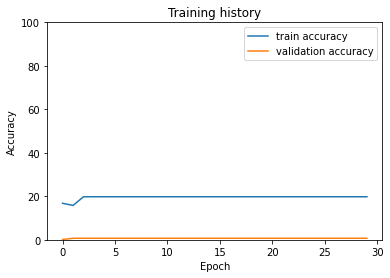

In [14]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 100]);